In [1]:
pip install torch matplotlib


  Using cached sympy-1.14.0-py3-none-any.whl.metadata (12 kB)
   ---------------------------------------- 0.0/216.1 MB ? eta -:--:--
   ---------------------------------------- 0.5/216.1 MB 3.4 MB/s eta 0:01:05
   ---------------------------------------- 1.0/216.1 MB 3.1 MB/s eta 0:01:09
   ---------------------------------------- 1.8/216.1 MB 3.4 MB/s eta 0:01:04
   ---------------------------------------- 2.6/216.1 MB 3.4 MB/s eta 0:01:03
    --------------------------------------- 3.4/216.1 MB 3.5 MB/s eta 0:01:02
    --------------------------------------- 4.2/216.1 MB 3.5 MB/s eta 0:01:01
    --------------------------------------- 4.7/216.1 MB 3.4 MB/s eta 0:01:03
    --------------------------------------- 5.2/216.1 MB 3.3 MB/s eta 0:01:04
   - -------------------------------------- 6.0/216.1 MB 3.3 MB/s eta 0:01:05
   - -------------------------------------- 6.3/216.1 MB 3.2 MB/s eta 0:01:06
   - -------------------------------------- 7.1/216.1 MB 3.2 MB/s eta 0:01:07
   - ---

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

def generative_sine_wave(batch_size, seq_len):
    t = np.linspace(0, 2*np.pi, seq_len)
    data = np.array([np.sin(t + np.random.rand() * np.pi) for _ in range(batch_size)])
    return torch.tensor(data, dtype=torch.float32)

class ScoreNet(nn.Module):
    def __init__(self, seq_len):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(seq_len + 1, 128),
            nn.ReLU(),
            nn.Linear(128, seq_len)
        )

    def forward(self, x, t):
        t_embed = t.unsqueeze(1).repeat(1, x.size(1))   #[B, SEQ_LEN]
        x_in = torch.cat([x, t_embed[:, :1]], dim=1)
        return self.model(x_in)

In [7]:
seq_len = 50
epochs = 1000
batch_size = 64
device = 'cuda' if torch.cuda.is_available() else 'cpu'

net = ScoreNet(seq_len).to(device)
optimizer = optim.Adam(net.parameters(), lr=1e-3)

def forward_noise(x, t):
    noise = torch.randn_like(x)
    return x + t[:, None] * noise, noise

for epoch in range(epochs):
    x0 = generative_sine_wave(batch_size, seq_len).to(device)
    t = torch.rand(batch_size, device=device) * 1.0  # t ∈ [0,1]

    xt, noise = forward_noise(x0, t)
    score_pred = net(xt, t)
    loss = ((score_pred + noise / (t[:, None] + 1e-5)) ** 2).mean()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

@torch.no_grad()
def sample(net, steps=20):
    xt = torch.randn(1, seq_len).to(device)
    for i in reversed(range(1, steps + 1)):
        t = torch.tensor([i/steps], device=device)
        score = net(xt, t)
        xt = xt - (1 / steps) * score # Probability Flow ODE
    return xt.squeeze().cpu().numpy()
        

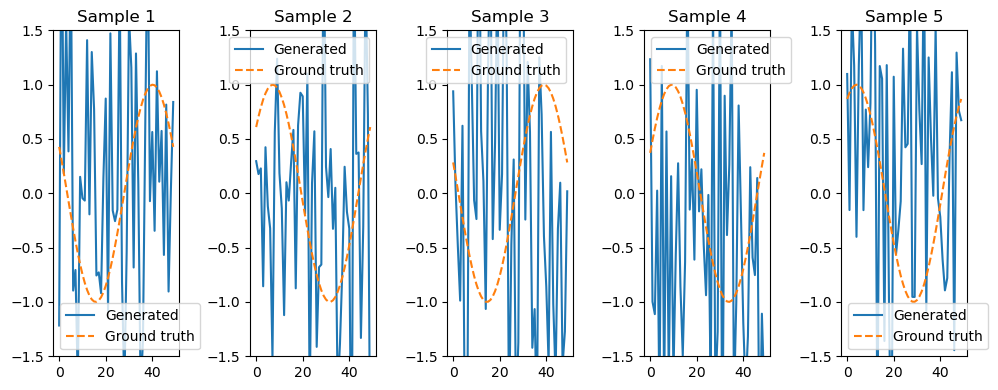

In [9]:
generated = [sample(net) for _ in range(5)]
true = generative_sine_wave(5, seq_len).numpy()

plt.figure(figsize=(10, 4))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.plot(generated[i], label='Generated')
    plt.plot(true[i], label='Ground truth', linestyle='dashed')
    plt.ylim(-1.5, 1.5)
    plt.title(f"Sample {i+1}")
    plt.legend()
plt.tight_layout()
plt.show()